In [ ]:
# ---------------- Project Title: Integrating Machine Learning and Bioinformatics to Identify Breast Cancer Biomarkers -------------- #

In [ ]:
# ------------------------------------------ Project Members: Mahima MS & Manasa Vema ------------------------------------------- #

In [ ]:
# ------------------------------------------------ Data Integration & Preprocessing ----------------------------------------- #

In [11]:
import pandas as pd
import numpy as np
from io import StringIO

# === Step 1: Load series matrix file and extract sample titles ===
series_file = "GSE24124_series_matrix.txt"

with open(series_file, "r", encoding="utf-8") as f:
    all_lines = f.readlines()

sample_title_line = next(l for l in all_lines if l.startswith("!Sample_title"))
sample_titles = sample_title_line.strip().split("\t")[1:]

data_lines = [line for line in all_lines if not line.startswith("!")]
expr_df = pd.read_csv(StringIO("".join(data_lines)), sep="\t", index_col=0)

# === Step 2: Load annotation and map probes ===
gpl_file = "GPL887-20438.txt"
gpl_df = pd.read_csv(gpl_file, sep="\t", comment="#", low_memory=False)

probe_map = gpl_df[["ID", "GENE_SYMBOL"]].dropna()
probe_map = probe_map[probe_map["GENE_SYMBOL"] != ""]

expr_df = expr_df.loc[expr_df.index.intersection(probe_map["ID"])]
expr_df = expr_df.merge(probe_map, left_index=True, right_on="ID")
expr_df.drop("ID", axis=1, inplace=True)
expr_df.set_index("GENE_SYMBOL", inplace=True)
expr_df = expr_df.groupby(expr_df.index).mean()
expr_df = expr_df.T  # rows = samples

# === Step 3: Assign labels from sample titles ===
sample_titles = [title.lower().strip() for title in sample_titles]
labels = [0 if "nontumor" in t else 1 if "tumor" in t else None for t in sample_titles]

# Add labels
expr_df["label"] = labels
expr_df = expr_df[expr_df["label"].notnull()]

# Move label column to front
cols = ["label"] + [col for col in expr_df.columns if col != "label"]
expr_df = expr_df[cols]

# === Step 5: Save and confirm ===
print("Final label distribution:")
print(expr_df["label"].value_counts())

# Save
expr_df.to_csv("GSE24124_cleaned_labeled_front.csv")
print("\nGSE24124_cleaned_labeled_front.csv saved with correct labels.")
print("\nData shape (samples × features+label):", expr_df.shape)


Final label distribution:
label
1    99
0    20
Name: count, dtype: int64

GSE24124_cleaned_labeled_front.csv saved with correct labels.

Data shape (samples × features+label): (119, 16547)


In [13]:
import pandas as pd
import numpy as np
from io import StringIO

# === Step 1: Load series matrix file and extract sample titles ===
series_file = "GSE32641_series_matrix.txt"

with open(series_file, "r", encoding="utf-8") as f:
    all_lines = f.readlines()

sample_title_line = next(l for l in all_lines if l.startswith("!Sample_title"))
sample_titles = sample_title_line.strip().split("\t")[1:]

data_lines = [line for line in all_lines if not line.startswith("!")]
expr_df = pd.read_csv(StringIO("".join(data_lines)), sep="\t", index_col=0)

# === Step 2: Load annotation file and map probes to gene symbols ===
gpl_file = "GPL887-20438.txt"
gpl_df = pd.read_csv(gpl_file, sep="\t", comment="#", low_memory=False)

probe_map = gpl_df[["ID", "GENE_SYMBOL"]].dropna()
probe_map = probe_map[probe_map["GENE_SYMBOL"] != ""]

expr_df = expr_df.loc[expr_df.index.intersection(probe_map["ID"])]
expr_df = expr_df.merge(probe_map, left_index=True, right_on="ID")
expr_df.drop("ID", axis=1, inplace=True)
expr_df.set_index("GENE_SYMBOL", inplace=True)
expr_df = expr_df.groupby(expr_df.index).mean()
expr_df = expr_df.T

# === Step 3: Label samples based on sample titles ===
sample_titles = [title.lower().strip() for title in sample_titles]
labels = [0 if "nontumor" in t else 1 if "tumor" in t else None for t in sample_titles]

expr_df["label"] = labels
expr_df = expr_df[expr_df["label"].notnull()]

# Move 'label' to front for easy Excel viewing
cols = ["label"] + [col for col in expr_df.columns if col != "label"]
expr_df = expr_df[cols]

# === Step 4: Optional log2 transform ===
features = expr_df.drop(columns=["label"])
if features.max().max() > 100:
    features = np.log2(features + 1)
    features["label"] = expr_df["label"]
    expr_df = features

# === Step 5: Save cleaned file ===
output_file = "GSE32641_cleaned_labeled_front.csv"
expr_df.to_csv(output_file)

print("\nFile saved as:", output_file)
print("Label counts:\n", expr_df["label"].value_counts())
print("\nData shape (samples × features):", expr_df.shape)



File saved as: GSE32641_cleaned_labeled_front.csv
Label counts:
 label
1    95
0     7
Name: count, dtype: int64

Data shape (samples × features): (102, 16547)


In [17]:
import pandas as pd
import numpy as np
from io import StringIO

# === Step 1: Load GSE36295 series matrix ===
series_file = "GSE36295_series_matrix.txt"
with open(series_file, "r", encoding="utf-8") as f:
    all_lines = f.readlines()

# Extract sample titles
sample_title_line = next(l for l in all_lines if l.startswith("!Sample_title"))
sample_titles = sample_title_line.strip().split("\t")[1:]

# Read expression data (skip metadata lines)
data_lines = [line for line in all_lines if not line.startswith("!")]
expr_df = pd.read_csv(StringIO("".join(data_lines)), sep="\t", index_col=0)

# === Step 2: Load corrected GPL file ===
gpl_path = "GPL6244-17930.txt"
gpl_df = pd.read_csv(gpl_path, sep="\t", comment="#", low_memory=False)

# === Step 3: Extract gene symbols ===
def extract_gene_symbols(text):
    try:
        parts = [p.strip() for p in text.split("//")]
        gene_symbols = [parts[i] for i in range(1, len(parts), 5) if parts[i].isalpha()]
        return ";".join(set(gene_symbols)) if gene_symbols else None
    except:
        return None

gpl_df["GENE_SYMBOL"] = gpl_df["gene_assignment"].apply(extract_gene_symbols)
probe_map = gpl_df[["ID", "GENE_SYMBOL"]].dropna()
probe_map = probe_map[probe_map["GENE_SYMBOL"] != "---"]
probe_map["GENE_SYMBOL"] = probe_map["GENE_SYMBOL"].str.strip()

# === Step 4: Merge with expression data ===
expr_df = expr_df.loc[expr_df.index.intersection(probe_map["ID"])]
expr_df = expr_df.merge(probe_map, left_index=True, right_on="ID")
expr_df.drop("ID", axis=1, inplace=True)
expr_df.set_index("GENE_SYMBOL", inplace=True)
expr_df = expr_df.groupby(expr_df.index).mean()
expr_df = expr_df.T

# === Step 5: Assign labels ===
sample_titles = [title.lower().strip() for title in sample_titles]
labels = []
valid_indices = []

for i, t in enumerate(sample_titles):
    if "normal" in t or "control" in t or "nontumor" in t:
        labels.append(0)
        valid_indices.append(i)
    elif "tumor" in t or "cancer" in t or "idc" in t:
        labels.append(1)
        valid_indices.append(i)
    else:
        continue

expr_df = expr_df.iloc[valid_indices]
expr_df["label"] = labels
cols = ["label"] + [c for c in expr_df.columns if c != "label"]
expr_df = expr_df[cols]

# === Step 6: Log2 transform if needed ===
features = expr_df.drop(columns=["label"])
if features.max().max() > 100:
    features = np.log2(features + 1)
    features["label"] = expr_df["label"]
    expr_df = features

# === Step 7: Save cleaned file ===
output_file = "GSE36295_cleaned_labeled_front.csv"
expr_df.to_csv(output_file)

print(f"\nFile saved as: {output_file}")
print("Label distribution:\n", expr_df['label'].value_counts())
print("Final gene count:", len(expr_df.columns) - 1)
print("\nData shape (samples × features+label):", expr_df.shape)



File saved as: GSE36295_cleaned_labeled_front.csv
Label distribution:
 label
1    45
0     5
Name: count, dtype: int64
Final gene count: 2539

Data shape (samples × features+label): (50, 2540)


In [20]:
# ---------------------------------------------- Merging Dataset ------------------------------------------#

In [22]:
import pandas as pd

# === Step 1: Load cleaned, labeled datasets ===
df1 = pd.read_csv("GSE24124_cleaned_labeled_front.csv", index_col=0)
df2 = pd.read_csv("GSE32641_cleaned_labeled_front.csv", index_col=0)
df3 = pd.read_csv("GSE36295_cleaned_labeled_front.csv", index_col=0)

# === Step 2: Separate features and labels ===
X1, y1 = df1.drop(columns=["label"]), df1["label"]
X2, y2 = df2.drop(columns=["label"]), df2["label"]
X3, y3 = df3.drop(columns=["label"]), df3["label"]

# === Step 3: Standardize gene column names ===
def clean_columns(df):
    df.columns = [col.strip().upper() for col in df.columns]
    return df

X1 = clean_columns(X1)
X2 = clean_columns(X2)
X3 = clean_columns(X3)

# === Step 4: Get common genes across all 3 datasets ===
common_genes = list(set(X1.columns) & set(X2.columns) & set(X3.columns))

print(f"Common genes retained: {len(common_genes)}")

# Filter each dataset to only include common genes
X1 = X1[common_genes]
X2 = X2[common_genes]
X3 = X3[common_genes]

# === Step 5: Merge all datasets ===
X_merged = pd.concat([X1, X2, X3])
y_merged = pd.concat([y1, y2, y3])

# Combine features and labels
merged_df = X_merged.copy()
merged_df["label"] = y_merged

# === Step 6: Save the merged dataset ===
output_file = "merged_all_3_datasets.csv"
merged_df.to_csv(output_file)

print("Merged dataset saved as:", output_file)
print("Label distribution:\n", merged_df["label"].value_counts())

print("\nSample gene columns from each dataset:")
print("\nGSE24124 genes:\n", list(X1.columns[:10]))
print("\nGSE32641 genes:\n", list(X2.columns[:10]))
print("\nGSE36295 genes:\n", list(X3.columns[:10]))


Common genes retained: 1941
Merged dataset saved as: merged_all_3_datasets.csv
Label distribution:
 label
1    239
0     32
Name: count, dtype: int64

Sample gene columns from each dataset:

GSE24124 genes:
 ['SELE', 'TEF', 'PFKL', 'ATCAY', 'HADHB', 'DPYS', 'IPMK', 'HBD', 'BRAF', 'NFIA']

GSE32641 genes:
 ['SELE', 'TEF', 'PFKL', 'ATCAY', 'HADHB', 'DPYS', 'IPMK', 'HBD', 'BRAF', 'NFIA']

GSE36295 genes:
 ['SELE', 'TEF', 'PFKL', 'ATCAY', 'HADHB', 'DPYS', 'IPMK', 'HBD', 'BRAF', 'NFIA']


In [24]:
common_genes = list(set(X1.columns) & set(X2.columns) & set(X3.columns))
print(f"Common genes retained: {len(common_genes)}")


with open("common_genes.txt", "w") as f:
    for gene in common_genes:
        f.write(gene + "\n")
print("\nCommon genes list saved to common_genes.txt")
print("\nMerged data shape (samples × features+label):", merged_df.shape)


Common genes retained: 1941

Common genes list saved to common_genes.txt

Merged data shape (samples × features+label): (271, 1942)


In [27]:
import pandas as pd
import numpy as np
import re
from io import StringIO
import os

# === Dataset cleaning of GSE42568_series_matrix file ===

# === Step 1: Load series matrix expression data ===
series_file = "GSE42568_series_matrix.txt"

# Skip metadata lines (start with "!")
with open(series_file, "r", encoding="utf-8") as f:
    lines = f.readlines()

data_start = next(i for i, line in enumerate(lines) if not line.startswith("!"))
expression_data_str = "".join(lines[data_start:])
expr_df = pd.read_csv(StringIO(expression_data_str), sep="\t", low_memory=False)
expr_df = expr_df.rename(columns={expr_df.columns[0]: "ProbeID"})
expr_df["ProbeID"] = expr_df["ProbeID"].str.strip()
expr_df = expr_df.set_index("ProbeID")
expr_df = expr_df.apply(pd.to_numeric, errors='coerce')  # convert to numeric
expr_df = expr_df.dropna(thresh=int(expr_df.shape[1] * 0.5))  # remove rows with >50% missing

print("Expression matrix shape:", expr_df.shape)

# === Step 2: Extract sample titles and GSM IDs ===
sample_title_line = next(l for l in lines if l.startswith("!Sample_title"))
sample_titles = sample_title_line.strip().split("\t")[1:]
sample_titles = [title.lower().strip().replace('"', '') for title in sample_titles]

sample_id_line = next(l for l in lines if l.startswith("!Sample_geo_accession"))
gsm_ids = sample_id_line.strip().split("\t")[1:]
gsm_ids = [s.strip().replace('"', '') for s in gsm_ids]

print("Extracted GSM IDs:", len(gsm_ids), "| First 5:", gsm_ids[:5])

# === Step 3: Read GPL annotation and map probes to genes ===
gpl_file = "GPL570-55999.txt"
probe_ids, gene_symbols = [], []

with open(gpl_file, 'r', encoding='utf-8') as file:
    for line in file:
        if line.startswith(("ID", "!", "#")):
            continue
        fields = line.strip().split('\t')
        if len(fields) < 2:
            continue
        probe_id = fields[0]
        line_text = ' '.join(fields)
        match = re.search(r"\s([A-Z0-9\-]{2,})\s+\d{3,6}", line_text)
        if match:
            gene_symbol = match.group(1)
            if gene_symbol.upper() != "HOMO":
                probe_ids.append(probe_id)
                gene_symbols.append(gene_symbol)

gpl_df = pd.DataFrame({"ProbeID": probe_ids, "GeneSymbol": gene_symbols})
gpl_df = gpl_df[gpl_df["GeneSymbol"] != ""].drop_duplicates()
print("Common ProbeIDs between expression and GPL:", len(expr_df.index.intersection(gpl_df["ProbeID"])))
print("Extracted probe-to-gene mappings:", gpl_df.shape)

# === Step 4: Merge expression with gene symbols ===
expr_df = expr_df.loc[expr_df.index.intersection(gpl_df["ProbeID"])]
merged_df = expr_df.merge(gpl_df, left_index=True, right_on="ProbeID")
merged_df = merged_df.drop(columns=["ProbeID"]).set_index("GeneSymbol")
merged_df = merged_df.groupby(merged_df.index).mean().T  # collapse duplicates and transpose

print("Transposed expression shape:", merged_df.shape)

# === Step 5: Add metadata columns (GSM ID, disease type, label) ===
labels = [0 if "normal breast" in t else 1 if "breast cancer" in t else None for t in sample_titles]
disease_types = ["normal breast" if l == 0 else "breast cancer" if l == 1 else "unknown" for l in labels]

# Add metadata
merged_df["GSM_ID"] = gsm_ids
merged_df["DiseaseType"] = disease_types
merged_df["label"] = labels

# Drop unknown labels
merged_df = merged_df[merged_df["label"].notnull()]

# Reorder: DiseaseType first, then GSM_ID, label, then gene data
meta_cols = ["DiseaseType", "GSM_ID", "label"]
gene_cols = [col for col in merged_df.columns if col not in meta_cols]
merged_df = merged_df[meta_cols + gene_cols]

print("Label counts:\n", merged_df["label"].value_counts())

# === Step 6: Log2 transform if needed ===
gene_data = merged_df[gene_cols].apply(pd.to_numeric, errors='coerce')
if gene_data.max().max() > 100:
    gene_data = np.log2(gene_data + 1)

# Recombine final matrix
merged_df = pd.concat([merged_df[meta_cols], gene_data], axis=1)

# === Step 7: Save cleaned data ===
output_file = "GSE42568_cleaned_labeled_with_GSM.csv"
merged_df.to_csv(output_file, index=False)

print("Final expression matrix shape:", merged_df.shape)
print("Label counts:\n", merged_df['label'].value_counts())
print("File saved:", output_file)





# === Dataset cleaning of GSE53752_series_matrix file ===

series_file = "GSE53752_series_matrix.txt"
gpl_file = "GPL7264-9589.txt"

# === Step 1: Load expression matrix ===
with open(series_file, "r", encoding="utf-8") as f:
    lines = f.readlines()

# Find where data starts
data_start = next(i for i, line in enumerate(lines) if not line.startswith("!"))
expression_data_str = "".join(lines[data_start:])
expr_df = pd.read_csv(StringIO(expression_data_str), sep="\t", low_memory=False)
expr_df = expr_df.rename(columns={expr_df.columns[0]: "ProbeID"})
expr_df["ProbeID"] = expr_df["ProbeID"].str.strip()
expr_df = expr_df.set_index("ProbeID")
expr_df = expr_df.apply(pd.to_numeric, errors='coerce')
expr_df = expr_df.dropna(thresh=int(expr_df.shape[1] * 0.5))

print("Loaded expression data:", expr_df.shape)

# === Step 2: Extract GSM IDs and Sample Titles ===
sample_id_line = next(l for l in lines if l.startswith("!Sample_geo_accession"))
gsm_ids = sample_id_line.strip().split("\t")[1:]
gsm_ids = [s.strip().replace('"', '') for s in gsm_ids]

sample_title_line = next(l for l in lines if l.startswith("!Sample_title"))
sample_titles = sample_title_line.strip().split("\t")[1:]
sample_titles = [title.lower().replace('"', '').strip() for title in sample_titles]

# Clean titles: remove text after "part_" or "tissue_" to simplify
clean_titles = []
for title in sample_titles:
    if "part_" in title:
        clean_title = title.split("_part")[0].strip()
    elif "tissue_" in title:
        clean_title = title.split("_tissue")[0].strip()
    else:
        clean_title = title.strip()
    clean_titles.append(clean_title)

# === Step 3: Label Samples based on Clean Titles ===
labels = []
disease_types = []
for title in sample_titles:
    if "normal breast" in title:
        labels.append(0)
        disease_types.append("normal breast")
    elif "breast tumor" in title:
        labels.append(1)
        disease_types.append("breast tumor")
    else:
        labels.append(None)
        disease_types.append("unknown")

print("Sample metadata prepared:", len(gsm_ids), "samples")

# === Step 4: Parse GPL file manually (ProbeID to GeneSymbol mapping) ===
probe_ids, gene_symbols = [], []
with open(gpl_file, 'r', encoding='utf-8') as file:
    for line in file:
        if line.startswith(("ID", "!", "#")):
            continue
        fields = line.strip().split('\t')
        if len(fields) < 7:
            continue
        probe_id = fields[0]
        gene_symbol = fields[6]
        if gene_symbol and gene_symbol != "---":
            probe_ids.append(probe_id)
            gene_symbols.append(gene_symbol)

gpl_df = pd.DataFrame({"ProbeID": probe_ids, "GeneSymbol": gene_symbols})
gpl_df = gpl_df.drop_duplicates()
gpl_df = gpl_df[gpl_df["GeneSymbol"].notnull()]
gpl_df = gpl_df[gpl_df["GeneSymbol"] != ""]

print("GPL probe-to-gene parsed:", gpl_df.shape)

# === Step 5: Match ProbeIDs ===
common_probes = expr_df.index.intersection(gpl_df["ProbeID"])
expr_df = expr_df.loc[common_probes]
probe_to_gene = dict(zip(gpl_df["ProbeID"], gpl_df["GeneSymbol"]))
expr_df.index = expr_df.index.map(probe_to_gene)
expr_df = expr_df.groupby(expr_df.index).mean()

print("Expression matrix after gene mapping:", expr_df.shape)

# === Step 6: Build final matrix ===
expr_df = expr_df.T  # Samples as rows

expr_df["GSM_ID"] = gsm_ids
expr_df["SampleTitle"] = clean_titles
expr_df["DiseaseType"] = disease_types
expr_df["label"] = labels

# Remove samples with unknown labels
expr_df = expr_df[expr_df["label"].notnull()]

# Reorder columns
meta_cols = ["DiseaseType", "SampleTitle", "GSM_ID", "label"]
gene_cols = [col for col in expr_df.columns if col not in meta_cols]
final_df = expr_df[meta_cols + gene_cols]

print("Final dataframe ready:", final_df.shape)

# === Step 7: Save output ===
final_df.to_csv("GSE53752_cleaned_sampletitles_labeled.csv", index=False)
print("Saved cleaned matrix with titles and labels!")





# === Dataset cleaning of GSE70947_series_matrix file ===

series_file = "GSE70947_series_matrix.txt"
gpl_file = "GPL13607-20416.txt"

# === Step 1: Load expression matrix ===
with open(series_file, "r", encoding="utf-8") as f:
    lines = f.readlines()

data_start = next(i for i, line in enumerate(lines) if not line.startswith("!"))
expression_data_str = "".join(lines[data_start:])
expr_df = pd.read_csv(StringIO(expression_data_str), sep="\t", low_memory=False)
expr_df = expr_df.rename(columns={expr_df.columns[0]: "ProbeID"})
expr_df["ProbeID"] = expr_df["ProbeID"].str.strip()
expr_df = expr_df.set_index("ProbeID")
expr_df = expr_df.apply(pd.to_numeric, errors='coerce')
expr_df = expr_df.dropna(thresh=int(expr_df.shape[1] * 0.5))
print("Expression matrix shape:", expr_df.shape)

# === Step 2: Extract GSM IDs and Sample Titles ===
sample_title_line = next(l for l in lines if l.startswith("!Sample_title"))
sample_titles = sample_title_line.strip().split("\t")[1:]
sample_titles = [t.lower().strip().replace('"', '') for t in sample_titles]

sample_id_line = next(l for l in lines if l.startswith("!Sample_geo_accession"))
gsm_ids = sample_id_line.strip().split("\t")[1:]
gsm_ids = [s.strip().replace('"', '') for s in gsm_ids]

# === Step 3: Read GPL file and extract gene symbols from gene_assignment ===
gpl_df = pd.read_csv(gpl_file, sep="\t", comment="#", low_memory=False)
gpl_df = gpl_df[["ID", "GeneName"]].dropna()

# Extract the first gene symbol from gene_assignment using regex
gpl_df["GeneSymbol"] = gpl_df["GeneName"]
gpl_df = gpl_df[["ID", "GeneSymbol"]].rename(columns={"ID": "ProbeID"}).dropna().drop_duplicates()

print("Extracted gene mappings from GPL:", gpl_df.shape)

# Ensure consistent formats for matching
expr_df.index = expr_df.index.astype(str).str.strip()
gpl_df["ProbeID"] = gpl_df["ProbeID"].astype(str).str.strip()

# Check overlap
common_probes = expr_df.index.intersection(gpl_df["ProbeID"])
print("Common probes between expr and GPL:", len(common_probes))

# Subset and map
expr_with_probe = expr_df.loc[common_probes]
probe_to_gene = dict(zip(gpl_df["ProbeID"], gpl_df["GeneSymbol"]))
expr_with_probe["GeneSymbol"] = expr_with_probe.index.map(probe_to_gene)

# Drop rows where GeneSymbol mapping failed
expr_with_probe = expr_with_probe[expr_with_probe["GeneSymbol"].notnull()]


# === Step 4: Map Probe IDs to Gene Symbols ===
expr_with_probe = expr_df.loc[expr_df.index.intersection(gpl_df["ProbeID"])]
probe_to_gene = dict(zip(gpl_df["ProbeID"], gpl_df["GeneSymbol"]))
expr_with_probe["GeneSymbol"] = expr_with_probe.index.map(probe_to_gene)

# === Step 5: Create Gene-Level Expression Matrix ===
gene_expr_df = expr_with_probe.drop(columns=["GeneSymbol"])
gene_expr_df.index = expr_with_probe["GeneSymbol"]
gene_expr_df = gene_expr_df.groupby(gene_expr_df.index).mean()

# === Step 6: Transpose and Add Metadata ===
# -- Gene-level
gene_expr_df = gene_expr_df.T
gene_expr_df["GSM_ID"] = gsm_ids
gene_expr_df["DiseaseType"] = ["normal breast" if "normal" in t else "tumor breast" for t in sample_titles]
gene_expr_df["label"] = [0 if "normal" in t else 1 for t in sample_titles]
meta_cols = ["DiseaseType", "GSM_ID", "label"]
gene_cols = [c for c in gene_expr_df.columns if c not in meta_cols]
gene_expr_df = gene_expr_df[meta_cols + gene_cols]

# -- Probe-level
probe_expr_df = expr_with_probe.drop(columns=["GeneSymbol"]).T
probe_expr_df["GSM_ID"] = gsm_ids
probe_expr_df["DiseaseType"] = ["normal" if "normal" in t else "tumor" for t in sample_titles]
probe_expr_df["label"] = [0 if "normal" in t else 1 for t in sample_titles]
probe_cols = [c for c in probe_expr_df.columns if c not in meta_cols]
probe_expr_df = probe_expr_df[meta_cols + probe_cols]

# === Step 7: Save both outputs ===
gene_expr_df.to_csv("GSE70947_gene_level_expression.csv", index=False)
probe_expr_df.to_csv("GSE70947_probe_level_expression.csv", index=False)

print("Gene-level shape:", gene_expr_df.shape)
print("Probe-level shape:", probe_expr_df.shape)
print("Saved both gene-level and probe-level expression matrices.")






# === Dataset cleaning of GSE109169_series_matrix file ===


series_file = "GSE109169_series_matrix.txt"
gpl_file = "GPL5175-3188.txt"

# === Step 1: Load expression matrix ===
with open(series_file, "r", encoding="utf-8") as f:
    lines = f.readlines()

data_start = next(i for i, line in enumerate(lines) if not line.startswith("!"))
expression_data_str = "".join(lines[data_start:])
expr_df = pd.read_csv(StringIO(expression_data_str), sep="\t", low_memory=False)
expr_df = expr_df.rename(columns={expr_df.columns[0]: "ProbeID"})
expr_df["ProbeID"] = expr_df["ProbeID"].str.strip()
expr_df = expr_df.set_index("ProbeID")
expr_df = expr_df.apply(pd.to_numeric, errors='coerce')
expr_df = expr_df.dropna(thresh=int(expr_df.shape[1] * 0.5))
print("Expression matrix shape:", expr_df.shape)

# === Step 2: Extract GSM IDs and Sample Titles ===
sample_title_line = next(l for l in lines if l.startswith("!Sample_title"))
sample_titles = sample_title_line.strip().split("\t")[1:]
sample_titles = [t.lower().strip().replace('"', '') for t in sample_titles]

sample_id_line = next(l for l in lines if l.startswith("!Sample_geo_accession"))
gsm_ids = sample_id_line.strip().split("\t")[1:]
gsm_ids = [s.strip().replace('"', '') for s in gsm_ids]

# === Step 3: Read GPL file and extract gene symbols from gene_assignment ===
gpl_df = pd.read_csv(gpl_file, sep="\t", comment="#", low_memory=False)
gpl_df = gpl_df[["ID", "gene_assignment"]].dropna()

# Extract the first gene symbol from gene_assignment using regex
gpl_df["GeneSymbol"] = gpl_df["gene_assignment"].str.extract(r'//\s*([A-Za-z0-9\-\.]+)\s*//')
gpl_df = gpl_df[["ID", "GeneSymbol"]].rename(columns={"ID": "ProbeID"}).dropna().drop_duplicates()

print("Extracted gene mappings from GPL:", gpl_df.shape)

# Ensure consistent formats for matching
expr_df.index = expr_df.index.astype(str).str.strip()
gpl_df["ProbeID"] = gpl_df["ProbeID"].astype(str).str.strip()

# Check overlap
common_probes = expr_df.index.intersection(gpl_df["ProbeID"])
print("Common probes between expr and GPL:", len(common_probes))

# Subset and map
expr_with_probe = expr_df.loc[common_probes]
probe_to_gene = dict(zip(gpl_df["ProbeID"], gpl_df["GeneSymbol"]))
expr_with_probe["GeneSymbol"] = expr_with_probe.index.map(probe_to_gene)

# Drop rows where GeneSymbol mapping failed
expr_with_probe = expr_with_probe[expr_with_probe["GeneSymbol"].notnull()]


# === Step 4: Map Probe IDs to Gene Symbols ===
expr_with_probe = expr_df.loc[expr_df.index.intersection(gpl_df["ProbeID"])]
probe_to_gene = dict(zip(gpl_df["ProbeID"], gpl_df["GeneSymbol"]))
expr_with_probe["GeneSymbol"] = expr_with_probe.index.map(probe_to_gene)

# === Step 5: Create Gene-Level Expression Matrix ===
gene_expr_df = expr_with_probe.drop(columns=["GeneSymbol"])
gene_expr_df.index = expr_with_probe["GeneSymbol"]
gene_expr_df = gene_expr_df.groupby(gene_expr_df.index).mean()

# === Step 6: Transpose and Add Metadata ===
# -- Gene-level
gene_expr_df = gene_expr_df.T
gene_expr_df["GSM_ID"] = gsm_ids
gene_expr_df["DiseaseType"] = ["normal breast" if "normal" in t else "tumor breast" for t in sample_titles]
gene_expr_df["label"] = [0 if "normal" in t else 1 for t in sample_titles]
meta_cols = ["DiseaseType", "GSM_ID", "label"]
gene_cols = [c for c in gene_expr_df.columns if c not in meta_cols]
gene_expr_df = gene_expr_df[meta_cols + gene_cols]

# -- Probe-level
probe_expr_df = expr_with_probe.drop(columns=["GeneSymbol"]).T
probe_expr_df["GSM_ID"] = gsm_ids
probe_expr_df["DiseaseType"] = ["normal" if "normal" in t else "tumor" for t in sample_titles]
probe_expr_df["label"] = [0 if "normal" in t else 1 for t in sample_titles]
probe_cols = [c for c in probe_expr_df.columns if c not in meta_cols]
probe_expr_df = probe_expr_df[meta_cols + probe_cols]

# === Step 7: Save both outputs ===
gene_expr_df.to_csv("GSE109169_gene_level_expression.csv", index=False)
probe_expr_df.to_csv("GSE109169_probe_level_expression.csv", index=False)

print("Gene-level shape:", gene_expr_df.shape)
print("Probe-level shape:", probe_expr_df.shape)
print("Saved both gene-level and probe-level expression matrices.")




# Merging of gene Expression Data of common genes 

# === Load datasets ===
df1 = pd.read_csv("GSE70947_gene_level_expression.csv")
df2 = pd.read_csv("GSE109169_gene_level_expression.csv")
df3 = pd.read_csv("GSE53752_cleaned_sampletitles_labeled.csv")  # Update path if needed
df4 = pd.read_csv("GSE42568_cleaned_labeled_with_GSM.csv")      # Update path if needed

# === Clean column names ===
def clean_cols(df):
    df.columns = [col.strip().upper() for col in df.columns]
    return df

df1, df2, df3, df4 = map(clean_cols, [df1, df2, df3, df4])

# === Define metadata columns ===
meta_cols = ["LABEL", "DISEASETYPE", "GSM_ID"]

# === Extract gene columns ===
genes1 = [col for col in df1.columns if col not in meta_cols]
genes2 = [col for col in df2.columns if col not in meta_cols]
genes3 = [col for col in df3.columns if col not in meta_cols]
genes4 = [col for col in df4.columns if col not in meta_cols]

# === Merge df1 and df2 on common genes ===
common_genes_1 = sorted(list(set(genes1) & set(genes2)))
merged1 = pd.concat([
    df1[meta_cols + common_genes_1],
    df2[meta_cols + common_genes_1]
], ignore_index=True)

# Save merged df1 + df2
merged1.to_csv("merged_70947_109169.csv", index=False)
with open("common_genes_70947_109169.txt", "w") as f:
    f.writelines(g + "\n" for g in common_genes_1)

# === Merge df3 and df4 on common genes ===
common_genes_2 = sorted(list(set(genes3) & set(genes4)))
merged2 = pd.concat([
    df3[meta_cols + common_genes_2],
    df4[meta_cols + common_genes_2]
], ignore_index=True)

# Save merged df3 + df4
merged2.to_csv("merged_GSE42568_GSE53752.csv", index=False)
with open("common_genes_GSE42568_GSE53752.txt", "w") as f:
    f.writelines(g + "\n" for g in common_genes_2)

# === Summary ===
print(f"Merged GSE70947 + GSE109169 → Shape: {merged1.shape} | Genes: {len(common_genes_1)}")
print(f"Merged GSE53752 + GSE42568 → Shape: {merged2.shape} | Genes: {len(common_genes_2)}")


Expression matrix shape: (54678, 121)
Extracted GSM IDs: 121 | First 5: ['GSM1045191', 'GSM1045192', 'GSM1045193', 'GSM1045194', 'GSM1045195']
Common ProbeIDs between expression and GPL: 43294
Extracted probe-to-gene mappings: (43294, 2)
Transposed expression shape: (121, 20364)
Label counts:
 label
1    104
0     17
Name: count, dtype: int64
Final expression matrix shape: (121, 20367)
Label counts:
 label
1    104
0     17
Name: count, dtype: int64
File saved: GSE42568_cleaned_labeled_with_GSM.csv
Loaded expression data: (20135, 76)
Sample metadata prepared: 76 samples
GPL probe-to-gene parsed: (18703, 2)
Expression matrix after gene mapping: (16717, 76)
Final dataframe ready: (76, 16721)
Saved cleaned matrix with titles and labels!
Expression matrix shape: (62179, 296)
Extracted gene mappings from GPL: (62976, 2)
Common probes between expr and GPL: 62175
Gene-level shape: (296, 34713)
Probe-level shape: (296, 62178)
Saved both gene-level and probe-level expression matrices.
Expressio

In [33]:
import pandas as pd

# === Step 1: Load the files ===
df_all = pd.read_csv("merged_all_3_datasets.csv", index_col=0)
df_42568_53752 = pd.read_csv("merged_GSE42568_GSE53752.csv", index_col=0)

# === Step 2: Find common genes ===
common_genes = df_all.columns.intersection(df_42568_53752.columns)

# === Step 3: Subset both to common genes ===
df_all_common = df_all[common_genes]
df_42568_53752_common = df_42568_53752[common_genes]

# === Step 4: Concatenate rows ===
combined_df = pd.concat([df_all_common, df_42568_53752_common], axis=0)

# === Step 5: Check result ===
print("Combined shape from 5 datasets (samples × genes):", combined_df.shape)

# === Optional: Save to CSV ===
combined_df.to_csv("combined_all_5_datasets_common_genes.csv")


Combined shape from 5 datasets (samples × genes): (468, 1889)


In [ ]:
# ----------------------------------------------------- Imputation Step ------------------------------------------------#

In [35]:
!pip install pycombat
!pip install neuroCombat

In [37]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Load your dataset
df = pd.read_csv("Training Dataset.csv", index_col=0)

# Separate features and label
X = df.drop(columns=["label"])
y = df["label"]

# Impute only gene expression (X), leave y untouched
imputer = SimpleImputer(strategy="mean")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

# Recombine features and label
df_final = pd.concat([X_imputed, y], axis=1)

# Save to CSV
df_final.to_csv("imputed_gene_expression_Training Dataset.csv")

# Confirm
print("Imputation complete.")
print("Final shape:", df_final.shape)
print("Label column retained.")
print("\nAny NaNs left in the data?", df_final.isna().sum().sum() > 0)


Imputation complete.
Final shape: (468, 1855)
Label column retained.

Any NaNs left in the data? False


In [40]:
# ---------------------------------------------- Selecting Features using the LASSO Regression ------------------------------------------------ #

In [44]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

# === Step 1: Load the final dataset ===
final_df = pd.read_csv("imputed_gene_expression_Training Dataset.csv", index_col=0)

# === Step 2: Drop GSM_ID and DISEASETYPE if present ===
final_df = final_df.drop(columns=[col for col in ["GSM_ID", "DISEASETYPE"] if col in final_df.columns])

# === Step 3: Split features and label ===
X = final_df.drop(columns=["label"])
y = final_df["label"]

# === Step 4: Scale features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Step 5: Stratified train-validation split ===
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# === Step 6: LASSO with Logistic Regression CV ===
lasso = LogisticRegressionCV(
    Cs=10,
    cv=5,
    penalty='l1',
    solver='liblinear',
    scoring='roc_auc',
    max_iter=5000
)
lasso.fit(X_train, y_train)

# === Step 7: Extract selected genes ===
selected_mask = lasso.coef_[0] != 0
selected_genes = X.columns[selected_mask]

print(f"{len(selected_genes)} genes selected by LASSO")
print("\nSelected genes:", selected_genes.tolist())


28 genes selected by LASSO

Selected genes: ['OSM', 'LSR', 'EFHB', 'CPO', 'EHF', 'CIDEA', 'DSP', 'IKBKE', 'XG', 'COMP', 'CRTAM', 'AICDA', 'OMD', 'MME', 'LTF', 'BOLL', 'CSTA', 'GZMB', 'PENK', 'CHGA', 'MYOC', 'LRMP', 'ITGAD', 'HBB', 'POSTN', 'OGN', 'LIF', 'SELE']


In [47]:
# --------------------------------------------- Model Training and Validation -- Standard Model -------------------------------------- #

In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
import joblib

# === Step 1: Load the dataset ===
df = pd.read_csv("imputed_gene_expression_Training Dataset.csv", index_col=0)

# === Step 2: Drop GSM_ID and DISEASETYPE if present ===
df = df.drop(columns=[col for col in ["GSM_ID", "DISEASETYPE"] if col in df.columns])

# === Step 3: Use only the 28 LASSO-selected genes ===
selected_genes = ['OSM', 'LSR', 'EFHB', 'CPO', 'EHF', 'CIDEA', 'DSP', 'IKBKE', 'XG', 'COMP',
                  'CRTAM', 'AICDA', 'OMD', 'MME', 'LTF', 'BOLL', 'CSTA', 'GZMB', 'PENK', 'CHGA',
                  'MYOC', 'LRMP', 'ITGAD', 'HBB', 'POSTN', 'OGN', 'LIF', 'SELE']

X = df[selected_genes]
y = df['label']

# === Step 4: Stratified 80/20 split ===
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Step 5: Scale the features ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# === Step 6: Define and train models ===
models = {
    "Logistic Regression (LASSO)": LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', max_iter=1000),
    "Support Vector Machine (SVM)": SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "Gradient Boosting (GBM)": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Artificial Neural Network (ANN)": MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
}

# === Step 7: Train and Evaluate ===
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    y_prob = model.predict_proba(X_val_scaled)[:, 1]

    acc = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)
    f1 = f1_score(y_val, y_pred)
    
    cm = confusion_matrix(y_val, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    print(f"\n{name}")
    print(f"Accuracy:      {acc:.3f}")
    print(f"AUROC:         {auc:.3f}")
    print(f"F1-score:      {f1:.3f}")
    print(f"Sensitivity:   {sensitivity:.3f}")
    print(f"Specificity:   {specificity:.3f}")

# === Step 8: Save models and scaler ===
joblib.dump(scaler, "scaler.joblib")
for name, model in models.items():
    joblib.dump(model, f"{name.replace(' ', '_').lower()}_model.joblib")



Logistic Regression (LASSO)
Accuracy:      0.968
AUROC:         0.997
F1-score:      0.981
Sensitivity:   0.962
Specificity:   1.000

Support Vector Machine (SVM)
Accuracy:      0.989
AUROC:         0.997
F1-score:      0.994
Sensitivity:   1.000
Specificity:   0.933

Random Forest
Accuracy:      0.979
AUROC:         0.999
F1-score:      0.988
Sensitivity:   1.000
Specificity:   0.867

Gradient Boosting (GBM)
Accuracy:      0.979
AUROC:         0.970
F1-score:      0.987
Sensitivity:   0.987
Specificity:   0.933

Artificial Neural Network (ANN)
Accuracy:      0.979
AUROC:         0.998
F1-score:      0.988
Sensitivity:   1.000
Specificity:   0.867


In [51]:
# ----------------------------------------- Model Training and Validation -- SMOTE Model ------------------------------------- #

In [53]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib

# === Step 0: Limit number of threads to avoid crashing ===
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

# === Step 1: Load the training dataset ===
df = pd.read_csv("imputed_gene_expression_Training Dataset.csv", index_col=0)
df = df.drop(columns=[col for col in ["GSM_ID", "DISEASETYPE"] if col in df.columns])

# === Step 2: Select only LASSO-selected genes ===
selected_genes = ['OSM', 'LSR', 'EFHB', 'CPO', 'EHF', 'CIDEA', 'DSP', 'IKBKE', 'XG', 'COMP',
                  'CRTAM', 'AICDA', 'OMD', 'MME', 'LTF', 'BOLL', 'CSTA', 'GZMB', 'PENK', 'CHGA',
                  'MYOC', 'LRMP', 'ITGAD', 'HBB', 'POSTN', 'OGN', 'LIF', 'SELE']

X = df[selected_genes]
y = df["label"]

# === Step 3: Train-validation split ===
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Step 4: Standardize the features ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Save the scaler
joblib.dump(scaler, "scaler.joblib")

# === Step 5: Apply SMOTE to the training set only ===
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"SMOTE applied: Train samples before = {len(y_train)}, after = {len(y_train_resampled)}")

# === Step 6: Define models ===
models = {
    "logistic_regression_(lasso)_model_with_smote.joblib": LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000),
    "support_vector_machine_(svm)_model_with_smote.joblib": SVC(kernel='rbf', probability=True, random_state=42),
    "random_forest_model_with_smote.joblib": RandomForestClassifier(n_estimators=100, random_state=42),
    "gradient_boosting_(gbm)_model_with_smote.joblib": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "artificial_neural_network_(ann)_model_with_smote.joblib": MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
}

# === Step 7: Train, evaluate and save each model ===
for filename, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    joblib.dump(model, filename)

    y_pred = model.predict(X_val_scaled)
    y_prob = model.predict_proba(X_val_scaled)[:, 1]

    acc = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)
    f1 = f1_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    print(f"\n{filename.replace('_model_with_smote.joblib', '').replace('_', ' ').title()} (SMOTE)")
    print(f"Accuracy:      {acc:.3f}")
    print(f"AUROC:         {auc:.3f}")
    print(f"F1-score:      {f1:.3f}")
    print(f"Sensitivity:   {sensitivity:.3f}")
    print(f"Specificity:   {specificity:.3f}")


SMOTE applied: Train samples before = 374, after = 630

Logistic Regression (Lasso) (SMOTE)
Accuracy:      0.979
AUROC:         0.998
F1-score:      0.987
Sensitivity:   0.975
Specificity:   1.000

Support Vector Machine (Svm) (SMOTE)
Accuracy:      0.989
AUROC:         0.998
F1-score:      0.994
Sensitivity:   1.000
Specificity:   0.933

Random Forest (SMOTE)
Accuracy:      0.989
AUROC:         0.999
F1-score:      0.994
Sensitivity:   1.000
Specificity:   0.933

Gradient Boosting (Gbm) (SMOTE)
Accuracy:      0.979
AUROC:         0.964
F1-score:      0.987
Sensitivity:   0.987
Specificity:   0.933

Artificial Neural Network (Ann) (SMOTE)
Accuracy:      0.979
AUROC:         0.998
F1-score:      0.988
Sensitivity:   1.000
Specificity:   0.867


In [56]:
# -------------------------------------------------- External Testing ---------------------------------------------------------- #

In [57]:
# -------------------------------------------------- External Testing using Standard Model ------------------------------------------------- #

In [58]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
import joblib

# === Step 1: Load test data ===
test_df = pd.read_csv("merged_70947_109169 -- Train Data.csv", index_col=0)
test_df = test_df.reset_index().rename(columns={"LABEL": "label"})
test_df = test_df.drop(columns=[col for col in ["GSM_ID", "DISEASETYPE"] if col in test_df.columns])

# === Step 2: Separate features and label ===
X_test_all = test_df.drop(columns=["label"])
y_test = test_df["label"]

# === Step 3: Define selected genes from training ===
selected_genes = ['OSM', 'LSR', 'EFHB', 'CPO', 'EHF', 'CIDEA', 'DSP', 'IKBKE', 'XG', 'COMP',
                  'CRTAM', 'AICDA', 'OMD', 'MME', 'LTF', 'BOLL', 'CSTA', 'GZMB', 'PENK', 'CHGA',
                  'MYOC', 'LRMP', 'ITGAD', 'HBB', 'POSTN', 'OGN', 'LIF', 'SELE']

# === Step 4: Add missing genes with NaN ===
for gene in selected_genes:
    if gene not in X_test_all.columns:
        X_test_all[gene] = np.nan

# === Step 5: Reorder to match training order ===
X_test_all = X_test_all[selected_genes]

# === Step 6: Impute missing values using mean ===
imputer = SimpleImputer(strategy='mean')
X_test_imputed_array = imputer.fit_transform(X_test_all)

# Get valid (non-dropped) column names
retained_columns = X_test_all.columns[~np.all(X_test_all.isna().values, axis=0)]

# Convert to DataFrame with retained columns
X_test_imputed = pd.DataFrame(X_test_imputed_array, columns=retained_columns, index=X_test_all.index)

print("\nImputation complete.")
print("\nGenes used:", X_test_imputed.columns.tolist())
print("Genes missing from test data and dropped:", list(set(selected_genes) - set(retained_columns)))

# === Step 6B: Add back missing genes as zeros and reorder ===
missing_genes = list(set(selected_genes) - set(X_test_imputed.columns))
for gene in missing_genes:
    X_test_imputed[gene] = 0  # safe dummy value

# Reorder columns to match scaler training input
X_test_imputed = X_test_imputed[selected_genes]

# === Step 7: Load scaler and transform test data ===
scaler = joblib.load("scaler.joblib")
X_test_scaled = scaler.transform(X_test_imputed)

# === Step 8: Load trained models ===
models = {
    "Logistic Regression (LASSO)": joblib.load("logistic_regression_(lasso)_model.joblib"),
    "Support Vector Machine (SVM)": joblib.load("support_vector_machine_(svm)_model.joblib"),
    "Random Forest": joblib.load("random_forest_model.joblib"),
    "Gradient Boosting (GBM)": joblib.load("gradient_boosting_(gbm)_model.joblib"),
    "Artificial Neural Network (ANN)": joblib.load("artificial_neural_network_(ann)_model.joblib")
}

# === Step 9: Predict and evaluate ===
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    print(f"\n{name} — External Test Set Evaluation")
    print(f"Accuracy:      {acc:.3f}")
    print(f"AUROC:         {auc:.3f}")
    print(f"F1-score:      {f1:.3f}")
    print(f"Sensitivity:   {sensitivity:.3f}")
    print(f"Specificity:   {specificity:.3f}")


C:\Users\mmsid\anaconda3\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['ITGAD']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(



Imputation complete.

Genes used: ['OSM', 'LSR', 'EFHB', 'CPO', 'EHF', 'CIDEA', 'DSP', 'IKBKE', 'XG', 'COMP', 'CRTAM', 'AICDA', 'OMD', 'MME', 'LTF', 'BOLL', 'CSTA', 'GZMB', 'PENK', 'CHGA', 'MYOC', 'LRMP', 'HBB', 'POSTN', 'OGN', 'LIF', 'SELE']
Genes missing from test data and dropped: ['ITGAD']

Logistic Regression (LASSO) — External Test Set Evaluation
Accuracy:      0.775
AUROC:         0.885
F1-score:      0.713
Sensitivity:   0.561
Specificity:   0.988

Support Vector Machine (SVM) — External Test Set Evaluation
Accuracy:      0.572
AUROC:         0.479
F1-score:      0.700
Sensitivity:   1.000
Specificity:   0.145

Random Forest — External Test Set Evaluation
Accuracy:      0.659
AUROC:         0.861
F1-score:      0.726
Sensitivity:   0.902
Specificity:   0.416

Gradient Boosting (GBM) — External Test Set Evaluation
Accuracy:      0.558
AUROC:         0.562
F1-score:      0.215
Sensitivity:   0.121
Specificity:   0.994

Artificial Neural Network (ANN) — External Test Set Evaluati

In [62]:
# -------------------------------------------------- External Testing using SMOTE Model ------------------------------------------------- #

In [64]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
import joblib

# === Step 1: Load the test dataset ===
test_df = pd.read_csv("merged_70947_109169 -- Train Data.csv", index_col=0)
test_df = test_df.reset_index().rename(columns={"LABEL": "label"})
test_df = test_df.drop(columns=[col for col in ["GSM_ID", "DISEASETYPE"] if col in test_df.columns])

# === Step 2: Separate features and labels ===
X_test_all = test_df.drop(columns=["label"])
y_test = test_df["label"]

# === Step 3: Define LASSO-selected genes used in training ===
selected_genes = ['OSM', 'LSR', 'EFHB', 'CPO', 'EHF', 'CIDEA', 'DSP', 'IKBKE', 'XG', 'COMP',
                  'CRTAM', 'AICDA', 'OMD', 'MME', 'LTF', 'BOLL', 'CSTA', 'GZMB', 'PENK', 'CHGA',
                  'MYOC', 'LRMP', 'ITGAD', 'HBB', 'POSTN', 'OGN', 'LIF', 'SELE']

# === Step 4: Add missing genes with NaNs ===
for gene in selected_genes:
    if gene not in X_test_all.columns:
        X_test_all[gene] = np.nan

# === Step 5: Reorder columns to match training order ===
X_test_all = X_test_all[selected_genes]

# === Step 6: Impute missing values with mean strategy ===
imputer = SimpleImputer(strategy='mean')
X_test_imputed_array = imputer.fit_transform(X_test_all)

# Get retained columns after imputation (some may be dropped if all values were NaN)
retained_columns = X_test_all.columns[~np.all(X_test_all.isna().values, axis=0)]
X_test_imputed = pd.DataFrame(X_test_imputed_array, columns=retained_columns, index=X_test_all.index)

# === Step 6B: Add back missing (dropped) genes as zeros and reorder again ===
missing_genes = list(set(selected_genes) - set(retained_columns))
for gene in missing_genes:
    X_test_imputed[gene] = 0  # or np.nan if you'd prefer

X_test_imputed = X_test_imputed[selected_genes]  # final reordering

# === Step 7: Load the saved scaler (from SMOTE training) and scale the test data ===
scaler = joblib.load("scaler.joblib")
X_test_scaled = scaler.transform(X_test_imputed)

# === Step 8: Load SMOTE-trained models ===
models = {
    "Logistic Regression (LASSO)": joblib.load("logistic_regression_(lasso)_model_with_smote.joblib"),
    "Support Vector Machine (SVM)": joblib.load("support_vector_machine_(svm)_model_with_smote.joblib"),
    "Random Forest": joblib.load("random_forest_model_with_smote.joblib"),
    "Gradient Boosting (GBM)": joblib.load("gradient_boosting_(gbm)_model_with_smote.joblib"),
    "Artificial Neural Network (ANN)": joblib.load("artificial_neural_network_(ann)_model_with_smote.joblib")
}

# === Step 9: Predict and evaluate ===
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    print(f"\n{name} — External Test Set (SMOTE-trained) Evaluation")
    print(f"Accuracy:      {acc:.3f}")
    print(f"AUROC:         {auc:.3f}")
    print(f"F1-score:      {f1:.3f}")
    print(f"Sensitivity:   {sensitivity:.3f}")
    print(f"Specificity:   {specificity:.3f}")


C:\Users\mmsid\anaconda3\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['ITGAD']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(



Logistic Regression (LASSO) — External Test Set (SMOTE-trained) Evaluation
Accuracy:      0.754
AUROC:         0.882
F1-score:      0.679
Sensitivity:   0.520
Specificity:   0.988

Support Vector Machine (SVM) — External Test Set (SMOTE-trained) Evaluation
Accuracy:      0.572
AUROC:         0.529
F1-score:      0.700
Sensitivity:   1.000
Specificity:   0.145

Random Forest — External Test Set (SMOTE-trained) Evaluation
Accuracy:      0.630
AUROC:         0.866
F1-score:      0.418
Sensitivity:   0.266
Specificity:   0.994

Gradient Boosting (GBM) — External Test Set (SMOTE-trained) Evaluation
Accuracy:      0.558
AUROC:         0.699
F1-score:      0.215
Sensitivity:   0.121
Specificity:   0.994

Artificial Neural Network (ANN) — External Test Set (SMOTE-trained) Evaluation
Accuracy:      0.803
AUROC:         0.877
F1-score:      0.757
Sensitivity:   0.613
Specificity:   0.994


In [65]:
# -------------------------------------------------- Plot for ROC Curve Standard v/s SMOTE ------------------------------------------------- #

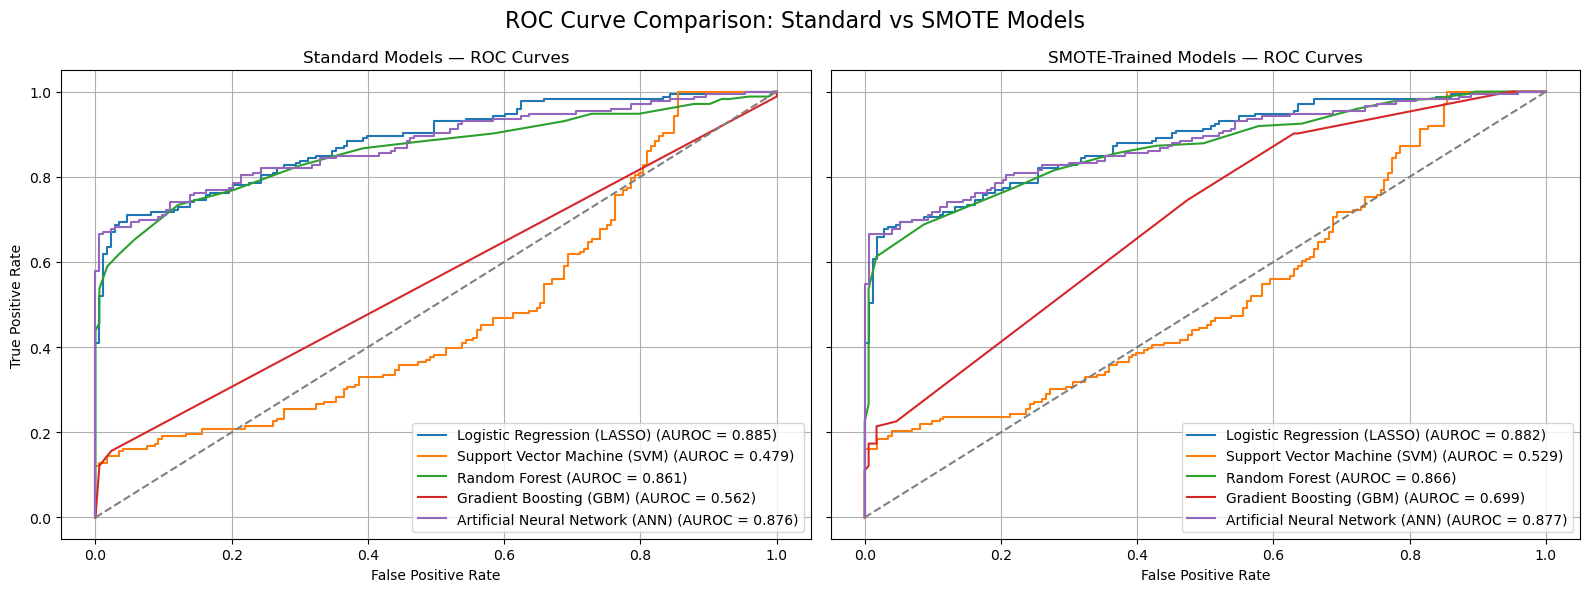

In [66]:
import pandas as pd
import numpy as np
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import joblib

# Load the standard (non-SMOTE) trained models
models_standard = {
    "Logistic Regression (LASSO)": joblib.load("logistic_regression_(lasso)_model.joblib"),
    "Support Vector Machine (SVM)": joblib.load("support_vector_machine_(svm)_model.joblib"),
    "Random Forest": joblib.load("random_forest_model.joblib"),
    "Gradient Boosting (GBM)": joblib.load("gradient_boosting_(gbm)_model.joblib"),
    "Artificial Neural Network (ANN)": joblib.load("artificial_neural_network_(ann)_model.joblib")
}


# Load the SMOTE trained models
models_smote = {
    "Logistic Regression (LASSO)": joblib.load("logistic_regression_(lasso)_model_with_smote.joblib"),
    "Support Vector Machine (SVM)": joblib.load("support_vector_machine_(svm)_model_with_smote.joblib"),
    "Random Forest": joblib.load("random_forest_model_with_smote.joblib"),
    "Gradient Boosting (GBM)": joblib.load("gradient_boosting_(gbm)_model_with_smote.joblib"),
    "Artificial Neural Network (ANN)": joblib.load("artificial_neural_network_(ann)_model_with_smote.joblib")
}


# === Plot ROC curves side-by-side ===
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot standard models
axes[0].set_title("Standard Models — ROC Curves")
for name, model in models_standard.items():
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, label=f"{name} (AUROC = {roc_auc:.3f})")
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend(loc="lower right")
axes[0].grid(True)

# Plot SMOTE models
axes[1].set_title("SMOTE-Trained Models — ROC Curves")
for name, model in models_smote.items():
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, label=f"{name} (AUROC = {roc_auc:.3f})")
axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[1].set_xlabel("False Positive Rate")
axes[1].legend(loc="lower right")
axes[1].grid(True)

plt.suptitle("ROC Curve Comparison: Standard vs SMOTE Models", fontsize=16)
plt.tight_layout()
plt.savefig("roc_comparison_standard_vs_smote.png")
plt.show()


In [71]:
# ---------------------------------------------------------- Biological Inference ----------------------------------------------------- #

Top LASSO-selected genes (by absolute coefficient):
     Gene  Coefficient
18   PENK    -2.288367
20   MYOC    -2.091095
9    COMP     2.052794
1     LSR     1.890866
2    EFHB    -1.099980
25    OGN    -0.852994
17   GZMB     0.758945
4     EHF     0.546495
10  CRTAM     0.430793
7   IKBKE     0.256706


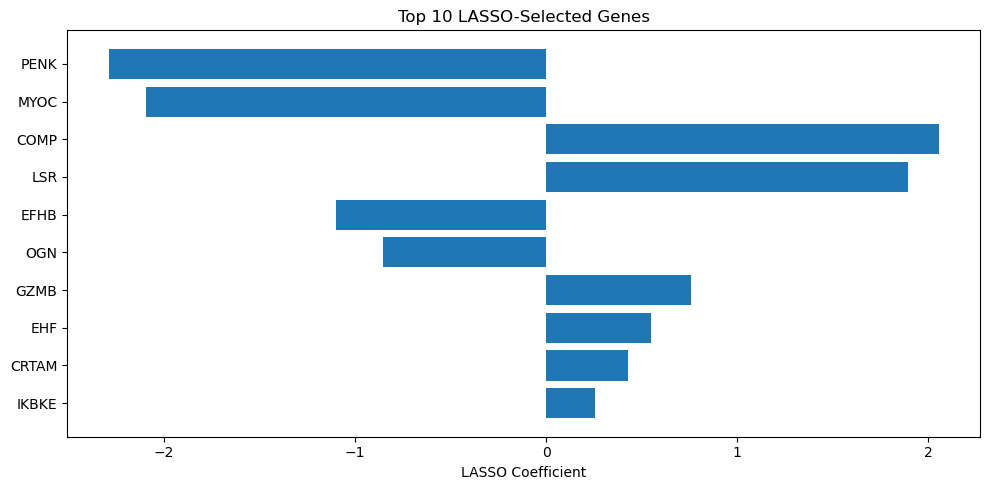

In [72]:
# Load LASSO model (if not already loaded)
lasso_model = models["Logistic Regression (LASSO)"]

# Get coefficients and their corresponding gene names
coef = lasso_model.coef_[0]
lasso_importance = pd.DataFrame({
    "Gene": selected_genes,
    "Coefficient": coef
})
lasso_importance = lasso_importance[lasso_importance["Coefficient"] != 0]
lasso_importance = lasso_importance.sort_values(by="Coefficient", key=abs, ascending=False)

# Display top genes
print("Top LASSO-selected genes (by absolute coefficient):")
print(lasso_importance.head(10))

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.barh(lasso_importance["Gene"].head(10), lasso_importance["Coefficient"].head(10))
plt.xlabel("LASSO Coefficient")
plt.title("Top 10 LASSO-Selected Genes")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [75]:
# ---------------------------------------------------------- ROC for each Top Gene ----------------------------------------------------- #

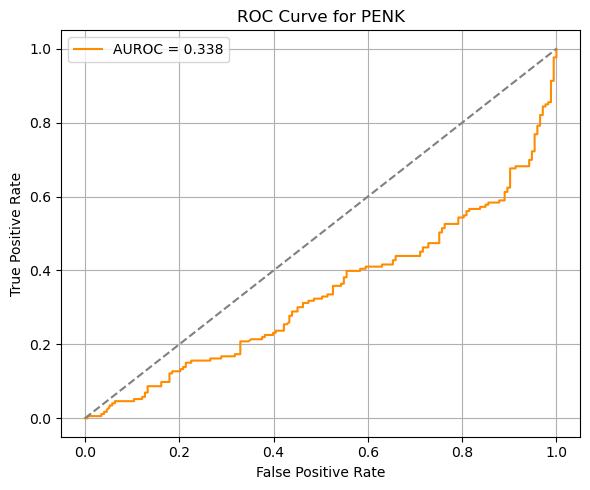

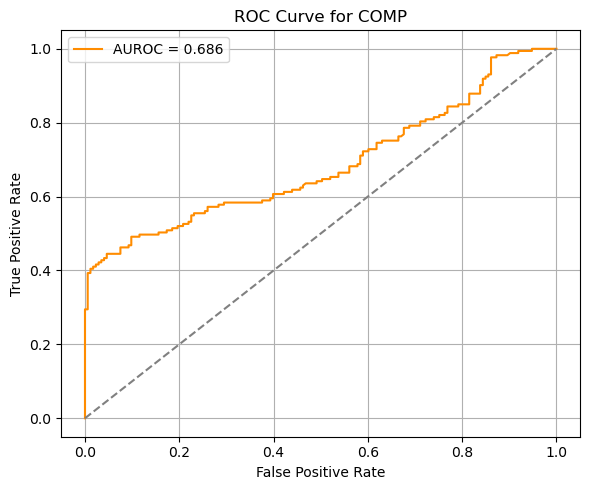

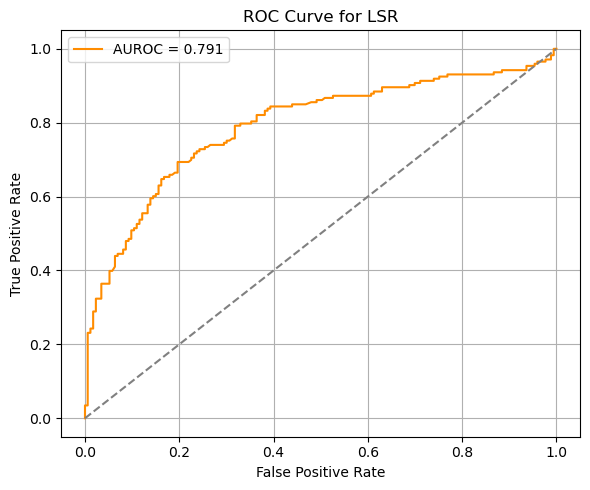

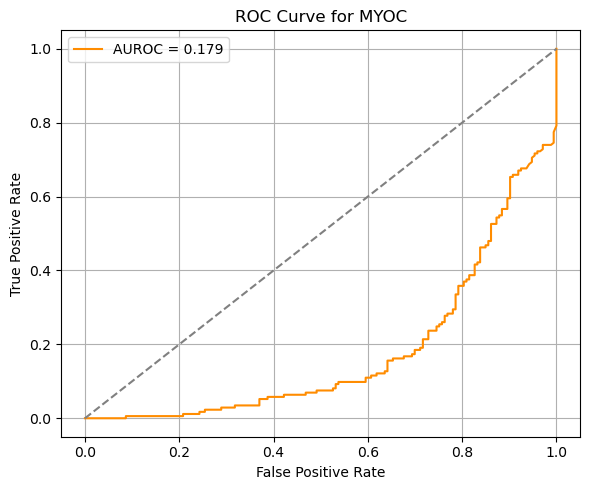

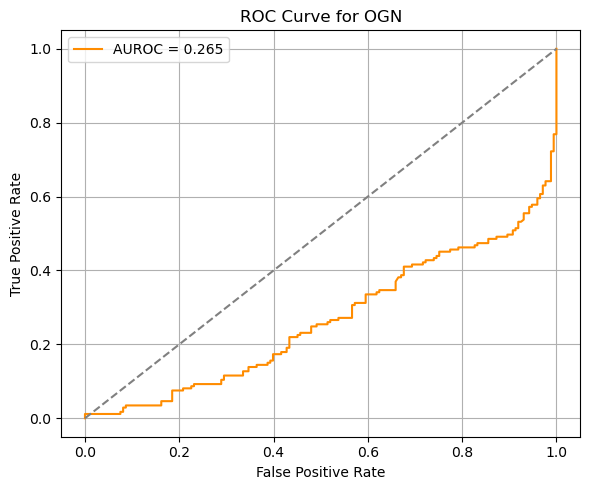

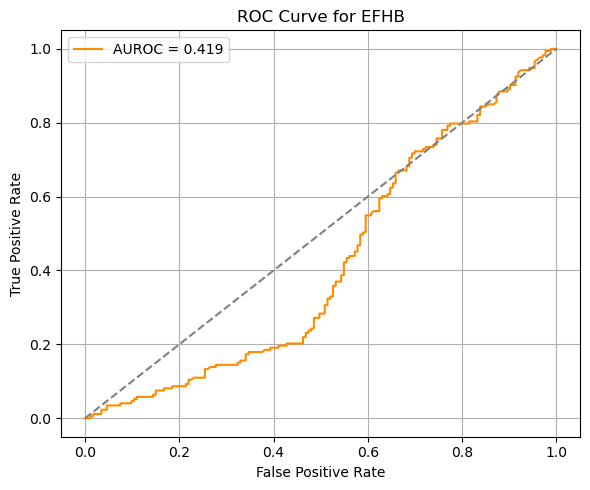

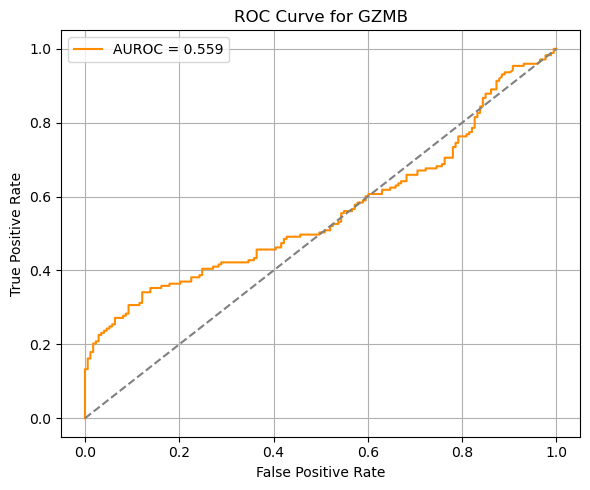

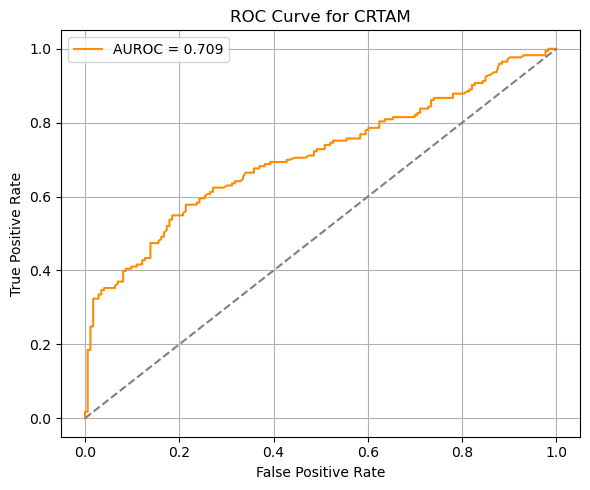

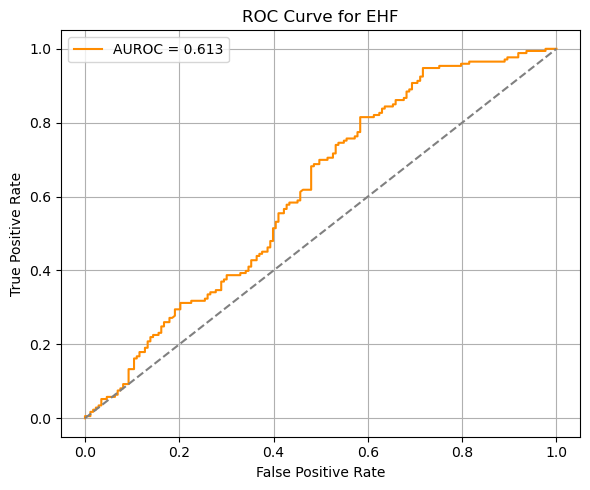

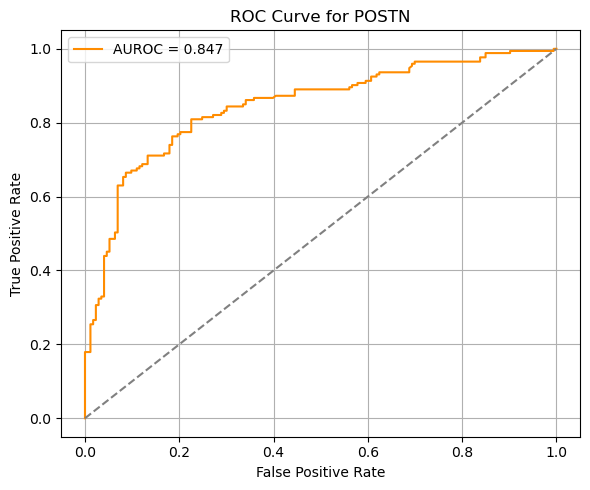

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# === Step 1: Load test set data and labels ===
X_test_imputed = pd.read_csv("X_test_imputed.csv", index_col=0)
y_test = pd.read_csv("y_test.csv", index_col=0).squeeze()

# === Step 2: Define top genes ===
top_genes = ['PENK', 'COMP', 'LSR', 'MYOC', 'OGN', 'EFHB', 'GZMB', 'CRTAM', 'EHF', 'POSTN']

# === Step 3: Plot & save each gene’s ROC curve ===
for gene in top_genes:
    y_prob = X_test_imputed[gene]
    auc_score = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUROC = {auc_score:.3f}", color='darkorange')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {gene}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"ROC_{gene}_Test.png", dpi=300)
    plt.show()


In [79]:
# ---------------------------------------------------------- Box Plot ----------------------------------------------------- #

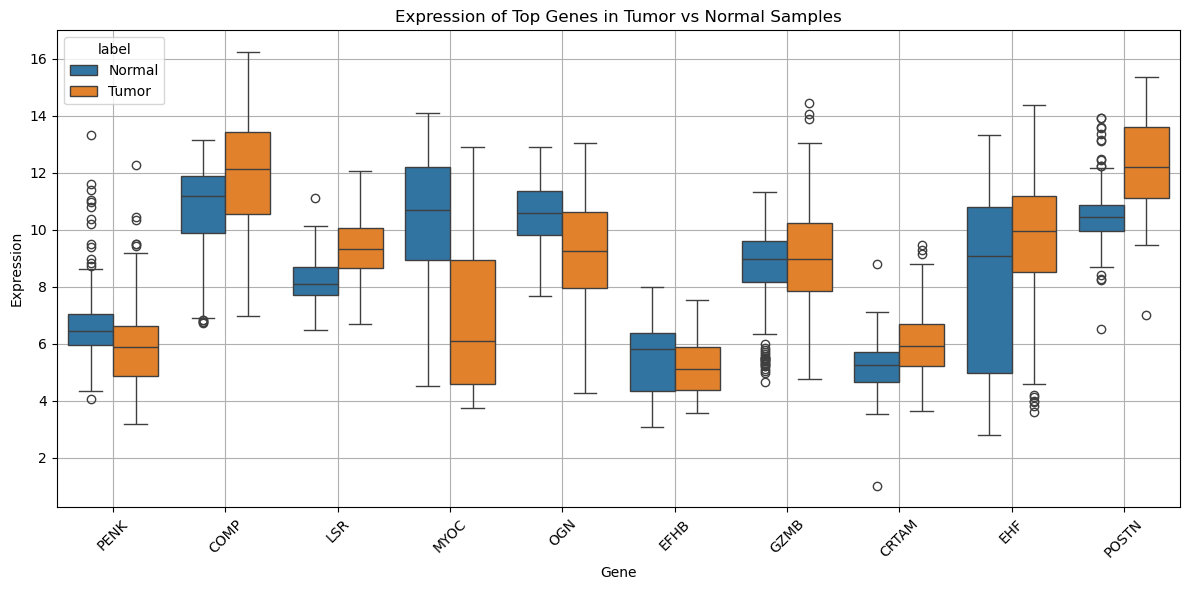


P-values for gene expression differences:
    Gene       p-value
9  POSTN  1.989718e-32
3   MYOC  2.468447e-28
2    LSR  7.900282e-23
4    OGN  1.465610e-17
7  CRTAM  2.278817e-12
1   COMP  1.329413e-08
0   PENK  1.487229e-06
8    EHF  1.003228e-05
5   EFHB  1.024683e-02
6   GZMB  1.209926e-02


In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# === Load imputed dataset ===
# Use X_test_imputed and y_test from your earlier steps
top_genes = ['PENK', 'COMP', 'LSR', 'MYOC', 'OGN', 'EFHB', 'GZMB', 'CRTAM', 'EHF', 'POSTN']

# Combine features and label into one DataFrame
gene_df = X_test_imputed[top_genes].copy()
gene_df['label'] = y_test.values  # add back label column

# Convert numeric label to string
gene_df['label'] = gene_df['label'].map({0: 'Normal', 1: 'Tumor'})

# === Melt for plotting ===
melted_df = gene_df.melt(id_vars='label', var_name='Gene', value_name='Expression')

# === Plot ===
plt.figure(figsize=(12, 6))
sns.boxplot(data=melted_df, x='Gene', y='Expression', hue='label')
plt.title("Expression of Top Genes in Tumor vs Normal Samples")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig("Box_plot.png")
plt.show()


# === Compute p-values ===
p_values = {}
for gene in top_genes:
    group0 = gene_df[gene_df['label'] == 'Normal'][gene]
    group1 = gene_df[gene_df['label'] == 'Tumor'][gene]
    _, p = ttest_ind(group0, group1)
    p_values[gene] = p

# Display p-values
pval_df = pd.DataFrame(list(p_values.items()), columns=["Gene", "p-value"]).sort_values("p-value")
print("\nP-values for gene expression differences:")
print(pval_df)


C:\Users\mmsid\AppData\Local\Temp\ipykernel_13944\399420115.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_top['label'] = y_test.values


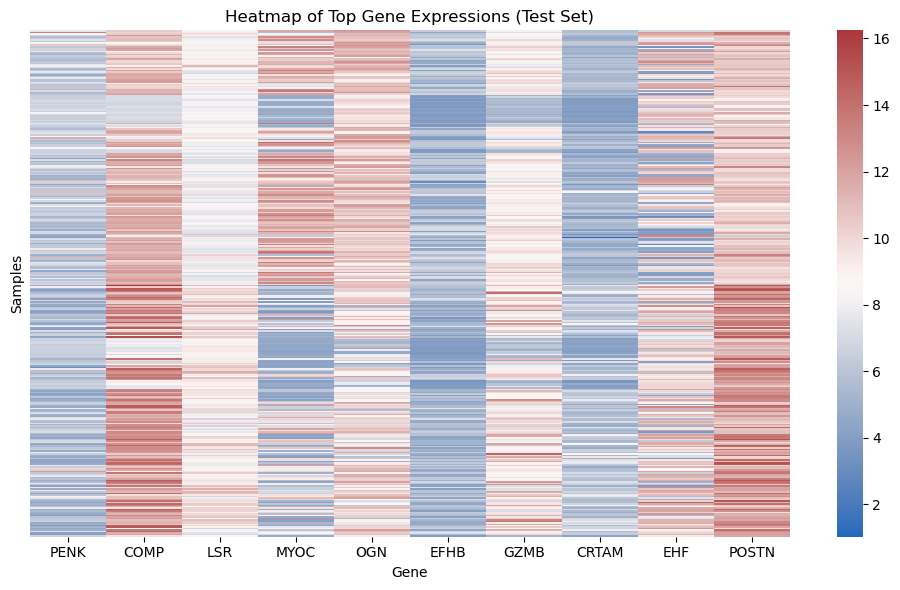

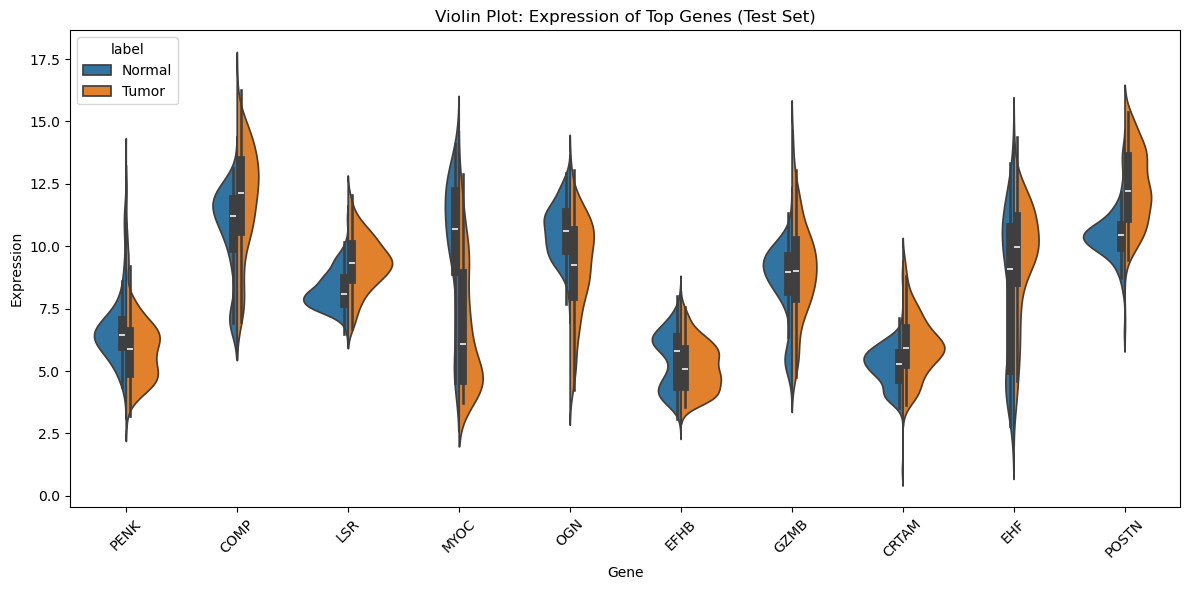

In [84]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Load imputed test data ===
X_test = pd.read_csv("X_test_imputed.csv", index_col=0)
y_test = pd.read_csv("y_test.csv", index_col=0).squeeze()  # Convert to Series

# === Top 10 LASSO-selected genes ===
top_genes = ['PENK', 'COMP', 'LSR', 'MYOC', 'OGN', 'EFHB', 'GZMB', 'CRTAM', 'EHF', 'POSTN']

# === Subset the data ===
X_top = X_test[top_genes]
X_top['label'] = y_test.values
X_top_sorted = X_top.sort_values("label")

# === 1. Heatmap ===
plt.figure(figsize=(10, 6))
sns.heatmap(X_top_sorted[top_genes], cmap="vlag", yticklabels=False)
plt.title("Heatmap of Top Gene Expressions (Test Set)")
plt.xlabel("Gene")
plt.ylabel("Samples")
plt.tight_layout()
plt.savefig("heatmap_test_top_genes.png")
plt.show()


# === 2. Violin plots ===
melted_df = X_top.melt(id_vars='label', var_name='Gene', value_name='Expression')
melted_df['label'] = melted_df['label'].map({0: 'Normal', 1: 'Tumor'})

plt.figure(figsize=(12, 6))
sns.violinplot(data=melted_df, x='Gene', y='Expression', hue='label', split=True)
plt.title("Violin Plot: Expression of Top Genes (Test Set)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("violinplot_test_top_genes.png")
plt.show()
